# Face Mask Detection

Dataset
https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?datasetId=667889

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import sys
import xmltodict
from collections import Counter
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image

In [2]:
torch.__version__

'1.11.0'

## Read input images and annotations

In [3]:
PATH_TO_DATASET = '/Users/yuhe/MaskDetection/archive'
PATH_TO_IMAGE = "/Users/yuhe/MaskDetection/archive/images"
PATH_TO_ANNOTATION = "/Users/yuhe/MaskDetection/archive/annotations"

In [4]:
img_names = []
xml_names = []
for dirpath, dirnames, filenames in os.walk(PATH_TO_DATASET):
    for filename in filenames:
        if filename[0] == ".":
            continue
        elif filename[-3:] == "xml":
            xml_names.append(os.path.join(dirpath, filename))
        else:
            img_names.append(os.path.join(dirpath, filename))
xml_names

['/Users/yuhe/MaskDetection/archive/annotations/maksssksksss299.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss528.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss272.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss514.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss500.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss266.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss716.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss702.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss845.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss689.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss851.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss138.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss662.xml',
 '/Users/yuhe/MaskDetection/archive/annotations/maksssksksss104.xml',
 '/Users/yuhe/MaskDe

In [5]:
raw_data = []
for xml_name in xml_names:
    with open(xml_name) as f:
        res = xmltodict.parse(f.read())
#         print(res)
    annotation = res["annotation"]["object"]
#     print(xml_name, type(annotation))
    if type(annotation) == list:
#         print(annotation)
        for i in range(len(annotation)):
#             print(annotation[i]["name"])
#             print(annotation[i]['bndbox'])
            raw_data.append(annotation[i]["name"])
    else:
#         print(annotation["name"])
        raw_data.append(annotation["name"])
    
# print(raw_data)

In [6]:
labels = Counter(raw_data).keys()
count = Counter(raw_data).values()
print(labels, count)

dict_keys(['without_mask', 'mask_weared_incorrect', 'with_mask']) dict_values([717, 123, 3232])


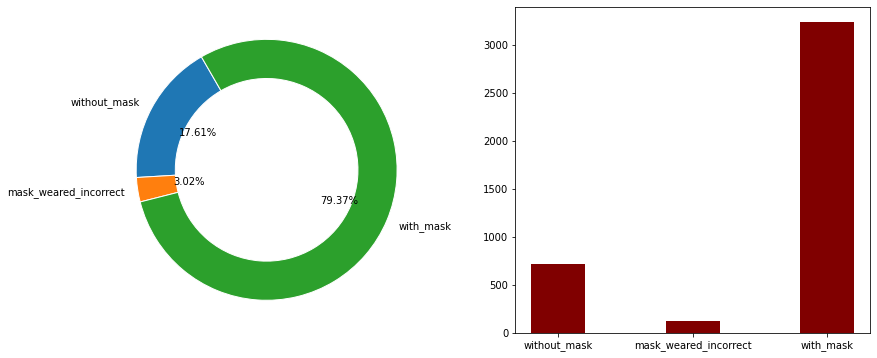

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))

ax1.pie(count, wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=labels, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(labels, list(count),
              color ='maroon',width = 0.4)

plt.show()


In [ ]:
PATH_TO_ANNOTATION

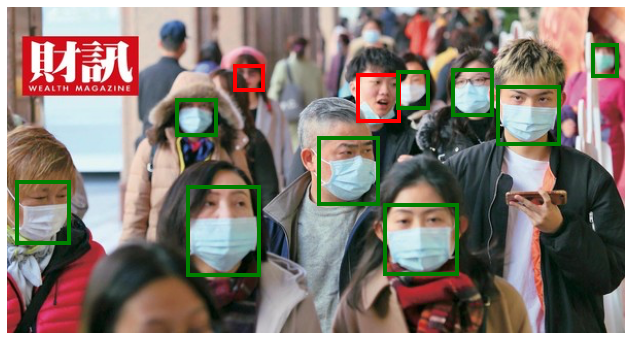

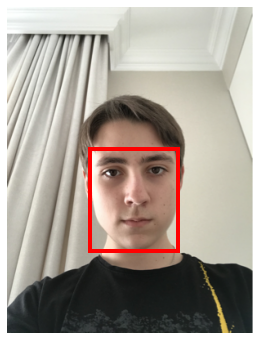

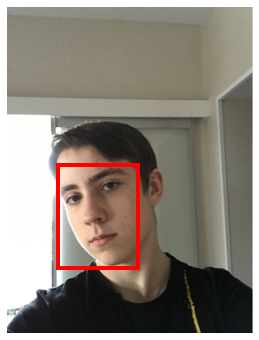

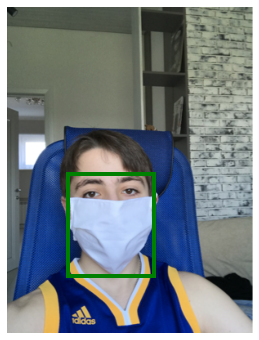

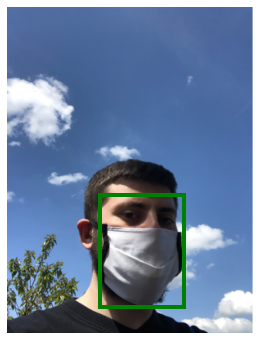

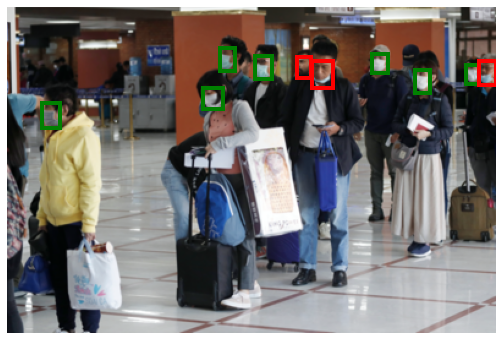

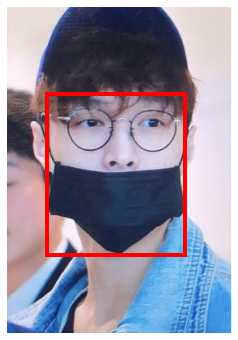

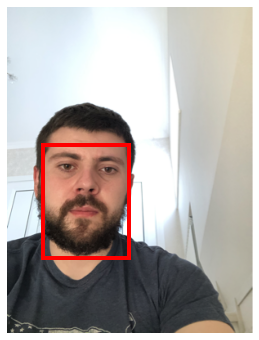

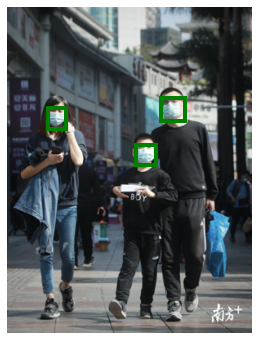

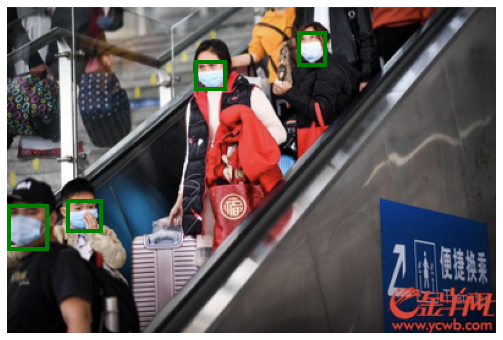

In [8]:
def draw(annotation,ax):
    # set bbx edge colors
    framecolor={'with_mask':'g','without_mask':'r','mask_weared_incorrect':'r'}
    
    xmin,ymin,xmax,ymax=list(map(int,annotation['bndbox'].values()))
    #[('xmin', '221'), ('ymin', '101'), ('xmax', '256'), ('ymax', '139')]
    
    rec=Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,
                  linewidth=4,edgecolor=framecolor[annotation['name']],facecolor='none')
    return rec
    
    
def face_cas(img):
    with open(PATH_TO_ANNOTATION+'/'+img[:-4]+'.xml') as f: # change png to xml
        res=xmltodict.parse(f.read())
        
    # print(type(res["annotation"]["object"]))
        
    image=plt.imread(os.path.join(PATH_TO_IMAGE, img))
    annotation=res["annotation"]["object"]
    
    fig,ax=plt.subplots(1,figsize=(14,6))
    ax.axis('off')
    if type(annotation)==list:
        for i in range(len(annotation)):
            # print(i)
            rec=draw(annotation[i],ax)
            ax.add_patch(rec)
    else:
        rec=draw(annotation,ax)
        ax.add_patch(rec)
    ax.imshow(image)

img_names_indi=[]   #extract the image name individually
for i in img_names:
    img_names_indi.append(i.split('/')[-1])

for i in range(10):
    face_cas(img_names_indi[i])

In [9]:
classes={'with_mask':1,"without_mask":0,'mask_weared_incorrect':0}

In [10]:
def trans(annotation,it,lt,i):
#     print(annotation['bndbox'].values())
    xmin,ymin,xmax,ymax=list(map(int,annotation['bndbox'].values()))
    #crop the image
    image=transforms.functional.crop(Image.open(PATH_TO_IMAGE+'/'+i).convert('RGB'),
                                     ymin,xmin,ymax-ymin,xmax-xmin)
    
    transformMethod=transforms.Compose([transforms.Resize((200,200)),
                                      transforms.ToTensor()])
    it.append(transformMethod(image))
    lt.append(torch.tensor(classes[annotation['name']]))
    return
    
def create_dataset(img_list):
    image_tensor=[]
    label_tensor=[]
    for i in img_list:
        with open(PATH_TO_ANNOTATION+'/'+i[:-4]+'.xml') as f:
            res=xmltodict.parse(f.read())
        annotation=res["annotation"]["object"]
        if type(annotation)==list:
            for j in range(len(annotation)):
                trans(annotation[j],image_tensor,label_tensor,i)
        else:
            trans(annotation,image_tensor,label_tensor,i)
    print(image_tensor)
    print(label_tensor)
    dataset=[[i,j] for i, j in zip(image_tensor,label_tensor)]
    return dataset
        
dataset=create_dataset(img_names_indi)

[tensor([[[0.4941, 0.4941, 0.5020,  ..., 0.5294, 0.5255, 0.5255],
         [0.4941, 0.4941, 0.5020,  ..., 0.5294, 0.5255, 0.5255],
         [0.4941, 0.4941, 0.5020,  ..., 0.5333, 0.5294, 0.5294],
         ...,
         [0.5373, 0.5373, 0.5294,  ..., 0.0941, 0.0980, 0.0980],
         [0.5412, 0.5412, 0.5333,  ..., 0.0941, 0.0980, 0.0980],
         [0.5412, 0.5412, 0.5333,  ..., 0.0941, 0.0980, 0.0980]],

        [[0.3412, 0.3412, 0.3490,  ..., 0.3765, 0.3725, 0.3725],
         [0.3412, 0.3412, 0.3490,  ..., 0.3765, 0.3725, 0.3725],
         [0.3412, 0.3412, 0.3490,  ..., 0.3843, 0.3804, 0.3804],
         ...,
         [0.5882, 0.5882, 0.5804,  ..., 0.1294, 0.1333, 0.1333],
         [0.5882, 0.5882, 0.5804,  ..., 0.1294, 0.1333, 0.1333],
         [0.5882, 0.5882, 0.5804,  ..., 0.1294, 0.1333, 0.1333]],

        [[0.2118, 0.2118, 0.2196,  ..., 0.2431, 0.2431, 0.2431],
         [0.2118, 0.2118, 0.2196,  ..., 0.2431, 0.2431, 0.2431],
         [0.2118, 0.2118, 0.2196,  ..., 0.2471, 0.2471, 0

In [11]:
len(img_names_indi)

853

In [12]:
# split dataset
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(f"Dataset Length: {len(dataset)}, train_size: {train_size}, test_size: {test_size}")

Dataset Length: 4072, train_size: 3257, test_size: 815


In [ ]:
model=models.resnet50(pretrained=True)

In [ ]:
# Setting Model Parameters, attribute requires_grad to false when feature extraction is done.
for param in model.parameters():
    param.requires_grad=False

In [ ]:
model

In [ ]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs, 2)

model.fc.out_features=last_layer
print('reinitialize model with output features as 2 :', model.fc.out_features)

In [ ]:
features_resnet50 = []
for key,value in model._modules.items():
    features_resnet50.append(value)

features_resnet50

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
for epoch in range(1,2): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
    

print('Finished Training')